In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from skimage import io
import numpy as np
import time
from PIL import Image

In [2]:
IMG_SIZE = (128,128)

class StylisedCifarDataset(Dataset):
    def __init__(self, data_path, random_seed = 42, target_transform = None, num_classes = None):
        super(StylisedCifarDataset, self).__init__()
        self.data_path = data_path

        self.is_classes_limited = False

        if num_classes != None:
            self.is_classes_limited = True
            self.num_classes = num_classes

        self.classes = []
        class_idx = 0
        for class_name in os.listdir(data_path):
            if not os.path.isdir(os.path.join(data_path,class_name)):
                continue
            self.classes.append(
               dict(
                   class_idx = class_idx,
                   class_name = class_name,
               ))
            class_idx += 1

            if self.is_classes_limited:
                if class_idx == self.num_classes:
                    break

        if not self.is_classes_limited:
            self.num_classes = len(self.classes)

        self.image_list = []
        for cls in self.classes:
            class_path = os.path.join(data_path, cls['class_name'])
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_list.append(dict(
                    cls = cls,
                    image_path = image_path,
                    image_name = image_name,
                ))

        self.img_idxes = np.arange(0,len(self.image_list))

#         np.random.seed(random_seed)
#         np.random.shuffle(self.img_idxes)

#         last_train_sample = int(len(self.img_idxes) * train_split)
#         if is_train:
#             self.img_idxes = self.img_idxes[:last_train_sample]
#         else:
#             self.img_idxes = self.img_idxes[last_train_sample:]

    def __len__(self):
        return len(self.img_idxes)

    def __getitem__(self, index):

        img_idx = self.img_idxes[index]
        img_info = self.image_list[img_idx]

        img = Image.open(img_info['image_path'])

        tr = transforms.ToTensor()
        img = tr(img)

#         tr = transforms.RandomCrop(IMG_SIZE)
#         img = tr(img)

#         if (img.shape[0] != 3):
#             img = img[0:3]

        return dict(image = img, cls = img_info['cls']['class_idx'], class_name = img_info['cls']['class_name'])

    def get_number_of_classes(self):
        return self.num_classes

    def get_number_of_samples(self):
        return self.__len__()

    def get_class_names(self):
        return [cls['class_name'] for cls in self.classes]

    def get_class_name(self, class_idx):
        return self.classes[class_idx]['class_name']

In [3]:
def get_stylised_cifar_datasets(data_path, num_classes = None):

#     random_seed = int(time.time())

    dataset = StylisedCifarDataset(data_path, num_classes = num_classes)

    return dataset

In [4]:
data_path_train = "../../cifar/training"
dataset_train = get_stylised_cifar_datasets(data_path_train)

data_path_val = "../../../afetit/train_split/validation/"
dataset_val = get_stylised_cifar_datasets(data_path_val)

data_path_test = "../../../afetit/train_split/testing/"
dataset_test = get_stylised_cifar_datasets(data_path_test)

print(f"Number of train samples {dataset_train.__len__()}")
print("Class names are: " + str(dataset_train.get_class_names()))
print("Class 3rd class name is: " + dataset_train.get_class_name(2))

print(f"Number of val samples {dataset_val.__len__()}")
print("Class names are: " + str(dataset_val.get_class_names()))

print(f"Number of test samples {dataset_test.__len__()}")
print("Class names are: " + str(dataset_test.get_class_names()))

BATCH_SIZE = 12

data_loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True)
data_loader_val = DataLoader(dataset_val, BATCH_SIZE, shuffle = True)
data_loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = True)

Number of train samples 36000
Class names are: ['1000000000', '0010000000', '0000000100', '0001000000', '0000100000', '0000001000', '0000000010', '0100000000', '0000000001', '0000010000']
Class 3rd class name is: 0000000100
Number of val samples 4000
Class names are: ['0000000100', '0000010000', '0100000000', '0000001000', '0010000000', '0000100000', '1000000000', '0000000001', '0001000000', '0000000010']
Number of test samples 10000
Class names are: ['0001000000', '0000100000', '0010000000', '0000001000', '0000000100', '1000000000', '0100000000', '0000010000', '0000000010', '0000000001']


Shape of batch['image'] torch.Size([12, 3, 32, 32])
Shape of batch['cls'] torch.Size([12])


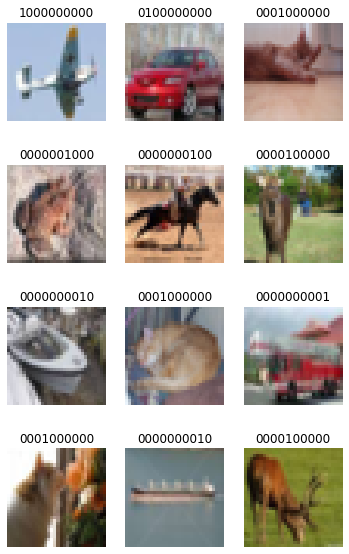

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(BATCH_SIZE//3,3, figsize=(6,10))

for batch in data_loader_train:

    print(f"Shape of batch['image'] {batch['image'].shape}")
    print(f"Shape of batch['cls'] {batch['cls'].shape}")

    for i in range(BATCH_SIZE):

        col = i % 3
        row = i // 3

        img = batch['image'][i].numpy()

        axes[row,col].set_axis_off()
        axes[row,col].set_title(batch['class_name'][i])
        axes[row,col].imshow(np.transpose(img,(1,2,0)))

    plt.show()

    break

In [5]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.resnet50().to(device)
# model = nn.DataParallel(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


min_val_loss = np.Inf
num_epoch = 1
# Main Loop
for epoch in range(num_epoch):  # loop over the dataset multiple times
    val_loss = 0
    running_loss = 0
    
    # Training Loop
    for i, batch in enumerate(data_loader_train, 0):
        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs = batch['image'].to(device)
        labels = batch['cls'].to(device)
    
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # Validation Loop
    for i, batch in enumerate(data_loader_val, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = batch['image'].to(device)
        labels = batch['cls'].to(device)

        # Update val loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss

    # Average val_loss
    val_loss = val_loss / len(data_loader_train)
    
    if val_loss < min_val_loss:
        print('saving model')
        torch.save(model.state_dict(), './unstylised_cifar.pth')
        min_val_loss = val_loss
    else:
        print('early stop')
        
correct = 0
total = 0
# Test Loop
model.load_state_dict(torch.load('./unstylised_cifar.pth'))
with torch.no_grad():
    for i, batch in enumerate(data_loader_test, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs = batch['image'].to(device)
        labels = batch['cls'].to(device)
        
        # Get output and update stats
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the dataset is: %d %%' % (100 * correct / total))

[1,   200] loss: 0.326
[1,   400] loss: 0.287
[1,   600] loss: 0.265
[1,   800] loss: 0.258
[1,  1000] loss: 0.253
[1,  1200] loss: 0.238
[1,  1400] loss: 0.234
[1,  1600] loss: 0.225
[1,  1800] loss: 0.218
[1,  2000] loss: 0.211
[1,  2200] loss: 0.214
[1,  2400] loss: 0.210
[1,  2600] loss: 0.211
[1,  2800] loss: 0.206
[1,  3000] loss: 0.204


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.17 GiB total capacity; 4.83 GiB already allocated; 1.69 MiB free; 996.89 MiB cached)